# Physics-Informed Neural Networks: Inverse Burgers' Equation
Author: John Wisniewski
Built upon starter code provided in CISC489 - Spring 2025
Additional modifications, training, and experiments completed independently.


# Solving an Inverse Problem using Physics-Informed Neural Networks (PINNs)
### Burger's Equation with PyTorch

In [13]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
torch.manual_seed(42)
np.random.seed(42)

## 1. Define the Neural Network

In [14]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.log_nu = nn.Parameter(torch.tensor([np.log(0.1)], requires_grad=True))

    def forward(self, x):
        return self.net(x)

    # Add a property to access nu calculated from log_nu
    @property
    def nu(self):
        return torch.exp(self.log_nu)

## 2. Define the PDE Residual for Burger's Equation

In [15]:
def pde_residual(model, x):
    x.requires_grad = True
    u = model(x)
    grads = grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]
    u_xx = grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    nu = model.nu
    # residual
    f = u_t + u * u_x - nu * u_xx  # Burger’s equation residual
    return f

## 3. Generate Collocation and Observational Data

In [16]:
def true_solution(x, t, nu):
    return -np.sin(np.pi * x) * np.exp(-np.pi**2 * nu * t)

N_f = 10000
N_u = 1000
nu = 0.1

x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)
X_f = torch.tensor(np.hstack([x_f, t_f]), dtype=torch.float32)
X_f = 2.0 * (X_f - 0.5)

x_u = np.random.rand(N_u, 1)
t_u = np.random.rand(N_u, 1)

u_u = true_solution(x_u, t_u, nu)
X_u = torch.tensor(np.hstack([x_u, t_u]), dtype=torch.float32)
X_u = 2.0 * (X_u - 0.5)

Y_u = torch.tensor(u_u, dtype=torch.float32)

## 4. Train the PINN

In [17]:
loss_history = []

# Stage 1: Train with Adam
model = PINN()
adam = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000
λ = 10.0  # Weight on data loss (tune this)
α = 1.0  # Weight on regularization loss (add this)

for epoch in range(epochs):
    adam.zero_grad()
    u_pred = model(X_u)
    f_pred = pde_residual(model, X_f)
    # Calculate nu from log_nu
    nu = torch.exp(model.log_nu)
    loss_u = torch.mean((u_pred - Y_u)**2)
    loss_f = torch.mean(f_pred**2)
    loss_reg = (nu - 0.1)**2
    loss = λ * loss_u + loss_f + α * loss_reg  # Include regularization loss
    loss.backward()
    adam.step()
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"[Adam] Epoch {epoch}, Loss: {loss.item():.4e}, inferred nu: {model.nu.item():.4f}, true nu: {nu.item():.2f}")

# Stage 2: Fine-tune with L-BFGS
lbfgs = torch.optim.LBFGS(model.parameters(),
                          max_iter=50000,
                          max_eval=50000,
                          history_size=50,
                          tolerance_grad=1e-7,
                          tolerance_change=1.0 * np.finfo(float).eps,
                          line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    u_pred = model(X_u)
    f_pred = pde_residual(model, X_f)
    nu = torch.exp(model.log_nu)
    loss_u = torch.mean((u_pred - Y_u)**2)
    loss_f = torch.mean(f_pred**2)
    loss_reg = (nu - 0.1)**2
    loss = λ * loss_u + loss_f + α * loss_reg
    loss.backward()
    return loss

loss_history.append(loss.item())

loss = lbfgs.step(closure)
print(f"[L-BFGS] Final Loss: {loss.item():.4e}, inferred nu: {model.nu.item():.4f}, true nu: {nu.item():.2f}")
# The .item() method is used to extract the numerical value from the tensors: loss and nu.

# Two-stage training: fast convergence with Adam followed by precise fine-tuning using L-BFGS for improved accuracy and stable PDE residual minimization


[Adam] Epoch 0, Loss: 2.1605e+00, inferred nu: 0.0999, true nu: 0.10
[Adam] Epoch 100, Loss: 2.2153e-01, inferred nu: 0.1101, true nu: 0.11
[Adam] Epoch 200, Loss: 9.5368e-02, inferred nu: 0.1155, true nu: 0.12
[Adam] Epoch 300, Loss: 7.7360e-02, inferred nu: 0.1185, true nu: 0.12
[Adam] Epoch 400, Loss: 6.3998e-02, inferred nu: 0.1338, true nu: 0.13
[Adam] Epoch 500, Loss: 5.4146e-02, inferred nu: 0.1492, true nu: 0.15
[Adam] Epoch 600, Loss: 4.6986e-02, inferred nu: 0.1603, true nu: 0.16
[Adam] Epoch 700, Loss: 4.2139e-02, inferred nu: 0.1658, true nu: 0.17
[Adam] Epoch 800, Loss: 3.9109e-02, inferred nu: 0.1671, true nu: 0.17
[Adam] Epoch 900, Loss: 3.7413e-02, inferred nu: 0.1667, true nu: 0.17
[Adam] Epoch 1000, Loss: 3.6532e-02, inferred nu: 0.1659, true nu: 0.17
[Adam] Epoch 1100, Loss: 3.6019e-02, inferred nu: 0.1654, true nu: 0.17
[Adam] Epoch 1200, Loss: 3.5655e-02, inferred nu: 0.1652, true nu: 0.17
[Adam] Epoch 1300, Loss: 3.5346e-02, inferred nu: 0.1651, true nu: 0.17
[Ada

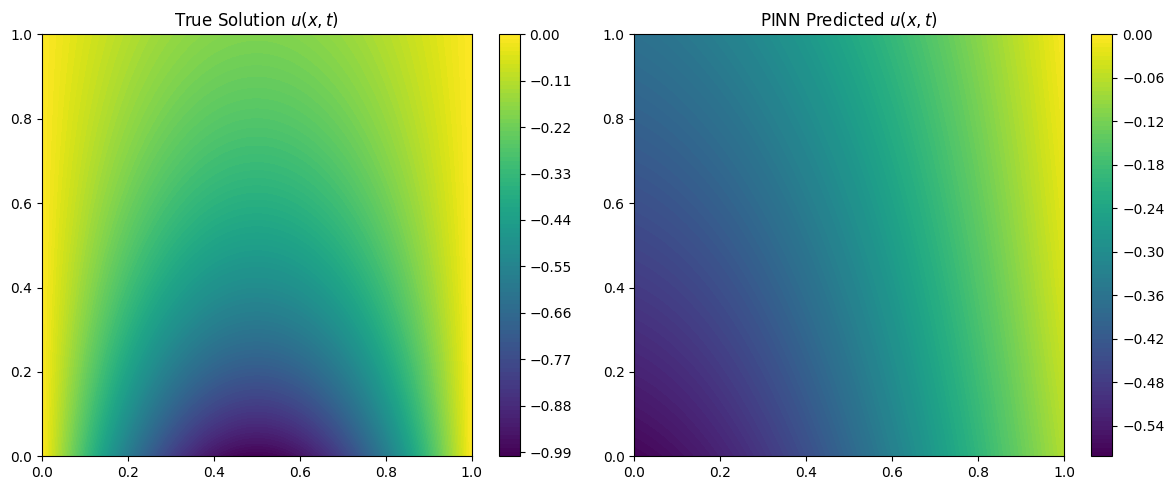

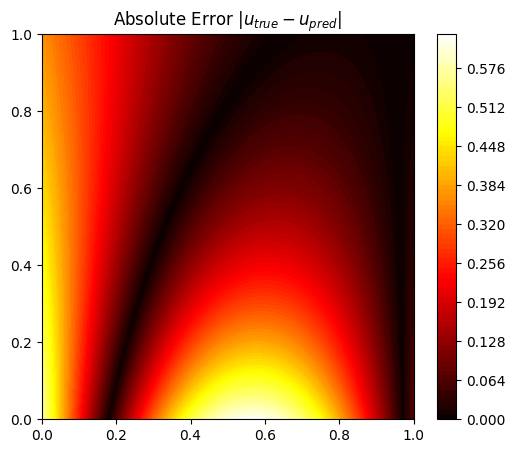

In [18]:
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Flatten to feed into model
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32)

with torch.no_grad():
    u_pred = model(XT_tensor).numpy().flatten()

# Ground truth
u_true = true_solution(X.flatten(), T.flatten(), nu.item()).flatten() # Change is on this line

plt.figure(figsize=(12, 5))

# True
plt.subplot(1, 2, 1)
plt.contourf(X, T, u_true.reshape(100, 100), levels=100, cmap='viridis')
plt.colorbar()
plt.title("True Solution $u(x,t)$")

# PINN Prediction
plt.subplot(1, 2, 2)
plt.contourf(X, T, u_pred.reshape(100, 100), levels=100, cmap='viridis')
plt.colorbar()
plt.title("PINN Predicted $u(x,t)$")

plt.tight_layout()
plt.show()

error = np.abs(u_true - u_pred)
plt.figure(figsize=(6, 5))
plt.contourf(X, T, error.reshape(100, 100), levels=100, cmap='hot')
plt.colorbar()
plt.title("Absolute Error $|u_{true} - u_{pred}|$")
plt.show()


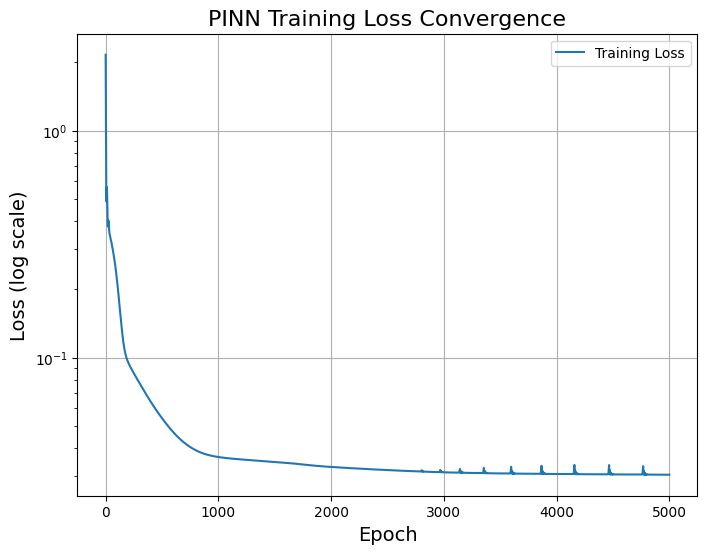

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.semilogy(loss_history, label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)
plt.title('PINN Training Loss Convergence', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()